# **Geo DataSet from Naver Cloud API**
37명 4개/ 5개씩 상점 분할하기
- **Total** : 150 개

## **1 Loading the table**
엑셀 원본데이터 불러오기

In [1]:
import pandas as pd
file_excel = './data/store.xlsx'
table_excel = pd.read_excel(file_excel)
table_excel.head(2)

,연번,상호명,점주명,연락처,주소,업종,행정동,사진,임대차,비고,Unnamed: 10
0,1,모든홍삼,주옥자,010-7908-0324,"은천로 28, 봉일프라자 나-120",기타판매,은천동,X,X,개별점포,NaN
1,2,종로떡집,김기철,010-4606-7280,국회단지길 21,떡집,은천동,X,X,개별점포,NaN


In [2]:
_table = [
#     ["01","24시셀프빨래방","민혜경", "010-4196-7646", "신림동 661-51", "빨래방"],
#     ["02","통큰바다장어","윤경희", "010-2434-8903", "관악구 조원로 111", "식당"],
#     ["03","KNC숯불바베큐","양하용", "010-9039-5153", "관악구 신사로 20길 50", "식당"],
    ["04","장수우렁불백", "이규엽", "010-2326-1063", "관악로148 2층", "식당"],
    ["05","뚱띵이왕갈비", "김영희", "010-9744-9428", "서림동94-258", "식당"],
]
column_name = list(table_excel.columns[:-5])
table_excel = pd.DataFrame(_table)
table_excel.columns = column_name
table_excel

,연번,상호명,점주명,연락처,주소,업종
0,04,장수우렁불백,이규엽,010-2326-1063,관악로148 2층,식당
1,05,뚱띵이왕갈비,김영희,010-9744-9428,서림동94-258,식당


In [12]:
_table = [
    ["01","24시셀프빨래방","민혜경", "010-4196-7646", "신림동 661-51", "빨래방"],
    ["02","통큰바다장어","윤경희", "010-2434-8903", "관악구 조원로 111", "식당"],
    ["03","KNC숯불바베큐","양하용", "010-9039-5153", "관악구 신사로 20길 50", "식당"],
]
column_name = list(table_excel.columns[:-5])
table_excel = pd.DataFrame(_table)
table_excel.columns = column_name
table_excel

,연번,상호명,점주명,연락처,주소,업종
0,01,24시셀프빨래방,민혜경,010-4196-7646,신림동 661-51,빨래방
1,02,통큰바다장어,윤경희,010-2434-8903,관악구 조원로 111,식당
2,03,KNC숯불바베큐,양하용,010-9039-5153,관악구 신사로 20길 50,식당


## **2 Naver API Column**
N Cloud API 를 활용한 위도경도값 추가하기
- **[Naver Map API Examples](https://navermaps.github.io/maps.js.ncp/docs/tutorial-3-drawing-restore.example.html)**
```
Client ID : wstocuk035
Client Secret : Na6VgNttRRMbehOv6Uswfw8iYld2INbvZMvGBOHQ
```

In [3]:
from data.arterior import Arterior
arterior = Arterior()

In [4]:
table_naver = arterior.naverAddressTableInsert(table_excel,'주소',2)
# table_naver.to_csv('./data/store_naver.csv', index=None)
table_naver.to_csv('./data/error_fixed.csv', index=None)
table_naver[table_naver["lon"]==""]
table_naver

100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


,연번,상호명,addressfull,addressroad,lon,lat,점주명,연락처,주소,업종
0,04,장수우렁불백,서울특별시 관악구 관악로 148,서울특별시 관악구 봉천동 1598-20,126.9525996,37.4784693,이규엽,010-2326-1063,관악로148 2층,식당
1,05,뚱띵이왕갈비,서울특별시 관악구 신림로 216,서울특별시 관악구 서림동 94-258,126.9375988,37.4767764,김영희,010-9744-9428,서림동94-258,식당


## **3 Validation Check**
테이블 내부의 데이터 유효성 확인하기
- NAVER MAP API 를 활용하여 데이터의 유효성 관계 확인하기

<br/>

# **K-Means Clustering the Address**
K-Means 구분을 활용한 묶음 데이터 생성
- **원칙 :** 거리가 가까운 업종끼리 묶는다 (종류는 무관)
- **예외1 :** 거리가 있으면 유사한 업종끼리 묶어서 난이도를 낮춘다
- **K Means 알고리즘** 은 **비지도학습** 으로, label 없이 자동으로 분류 기준을 세워서 동작 된다

## **1 Loading the table**
1. **K Means** 알고리즘을 활용하여 37개의 분류 데이터 생성
1. 생성된 데이터를 기준으로 4개, 5개씩 임의로 분류
1. 애매한 부분을 **KNN** 을 활용하여 Label 최종적 마무리 진행

In [3]:
import pandas as pd
table = pd.read_csv('./data/store_naver.csv')
table.head(2)

,연번,상호명,점주명,연락처,주소,addressfull,addressroad,lon,lat,업종,행정동,사진,임대차,비고,Unnamed: 10
0,1,모든홍삼,주옥자,010-7908-0324,"은천로 28, 봉일프라자 나-120",서울특별시 관악구 은천로 28 봉일프라자,서울특별시 관악구 봉천동 951-25 봉일프라자,126.938397,37.485887,기타판매,은천동,X,X,개별점포,NaN
1,2,종로떡집,김기철,010-4606-7280,국회단지길 21,서울특별시 관악구 국회단지길 21,서울특별시 관악구 봉천동 636-110,126.939588,37.487197,떡집,은천동,X,X,개별점포,NaN


/home/momukji/Python/Python/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 233 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/momukji/Python/Python/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 233 missing from current font.
  font.set_text(s, 0, flags=flags)


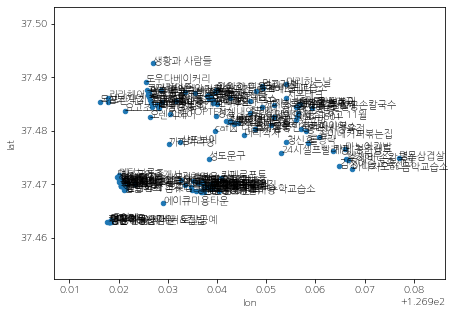

In [4]:
# Visualize
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rc('font', family='NanumGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# Drawing the Graph
fig, ax = plt.subplots(figsize=(7, 5))
table.plot.scatter(x='lon', y='lat', ax=ax)
for _ in table.index:
    ax.annotate(table.loc[_]['상호명'], (table.loc[_]['lon'], table.loc[_]['lat']))

## **2 K Means** 알고리즘을 활용하여 37개의 분류 데이터 생성
1. 생성된 데이터를 기준으로 4개, 5개씩 임의로 분류
1. 애매한 부분을 **KNN** 을 활용하여 Label 최종적 마무리 진행

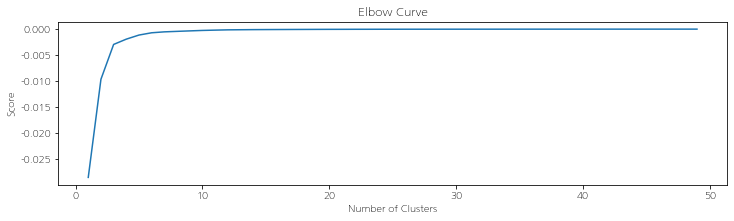

In [5]:
# Clustering 기준을 몇개로 할 것인지 점수를 확인
# 분석결과 : 완만한 상승곡선으로 크게 구분시 차이가 없다
from sklearn.cluster import KMeans
K_clusters = range(1,50)
kmeans = [ KMeans(n_clusters = _)  for _ in K_clusters ]
X_axis, Y_axis = table[['lat']], table[['lon']]
score  = [ kmeans[i].fit(Y_axis).score(Y_axis)  for i in range(len(kmeans)) ]

plt.figure(figsize=(12, 3)); plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters');plt.ylabel('Score'); plt.title('Elbow Curve')
plt.show()

In [6]:
# Compute k-means clustering.
from collections import Counter
kmeans = KMeans(n_clusters = 37, init ='k-means++')
kmeans.fit(table.loc[:,['lat','lon']]) 
table['label'] = kmeans.fit_predict(table.loc[:,['lat','lon']])
table['label'] = list(map(lambda x : x+1 , table['label'])) # 0 을 지우고 1개씩 더하기
result_count = Counter(table['label'].to_list())
result_count = sorted([f"Id{k:02d}:{v:02d}"  for k,v in result_count.items()])
", ".join(result_count)

'Id01:13, Id02:03, Id03:15, Id04:01, Id05:08, Id06:03, Id07:09, Id08:07, Id09:02, Id10:10, Id11:03, Id12:01, Id13:04, Id14:02, Id15:02, Id16:08, Id17:03, Id18:02, Id19:02, Id20:08, Id21:01, Id22:03, Id23:02, Id24:01, Id25:01, Id26:02, Id27:01, Id28:02, Id29:03, Id30:01, Id31:08, Id32:05, Id33:06, Id34:02, Id35:02, Id36:03, Id37:01'

## **3 Visualization**
시각화 만들기

/home/momukji/Python/Python/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 233 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/momukji/Python/Python/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 233 missing from current font.
  font.set_text(s, 0, flags=flags)


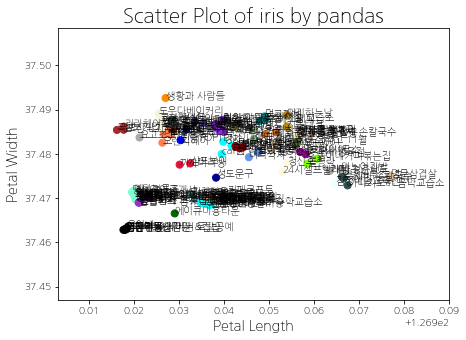

In [7]:
import matplotlib.colors as mcolors
color_names = list(mcolors.cnames.keys())
table['color'] = [color_names[_]  for _ in table["label"]]
fig, ax = plt.subplots(figsize=(7, 5))
table.plot(kind = 'scatter',
              x = 'lon', 
              y = 'lat', 
              s = 50, # marker size
              c = table['color'],
              ax = ax) # marker color by group
for _ in table.index:
    ax.annotate(table.loc[_]['상호명'], 
                (table.loc[_]['lon'], table.loc[_]['lat']), 
                fontsize=10) 
plt.title('Scatter Plot of iris by pandas', fontsize=20)
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.show()

<br/>

# **GEO 데이터 보정하기**
1. 주솟값이 일치하는 데이터들이 존재
1. 이로인해 시각화 작업시 중복값 확인이 불가능한 경우가 발생

## **1 Loading the table**
데이터를 불러온 뒤, 중복된 내용 확인하기

In [1]:
import pandas as pd
table = pd.read_csv('./data/store_naver.csv')
table.tail(2)

,연번,상호명,점주명,연락처,주소,addressfull,addressroad,lon,lat,업종,행정동,사진,임대차,비고,Unnamed: 10
148,149,스마일공인중개사사무소,장귀길,010-8249-0100,남부순환로214길 29,서울특별시 관악구 남부순환로214길 29,서울특별시 관악구 봉천동 881-17,126.947638,37.480334,부동산,청룡동,X,O,개별점포,NaN
149,150,컴플러스 컴퓨터,윤영중,010-8850-4114,난곡로24길 32,서울특별시 관악구 난곡로24길 32,서울특별시 관악구 신림동 655-36,126.921095,37.468968,기타,난곡동,O,O,난곡생활상권,NaN


In [2]:
from collections import Counter
_count_address = dict(Counter([_ for _ in table['addressfull']]))
_count_address = {k:str(v) for k, v in _count_address.items() if v != 1}
_count_address

{'서울특별시 관악구 남부순환로214길 29': '2',
 '서울특별시 관악구 난곡로24길 6': '3',
 '서울특별시 관악구 봉천로 465': '2',
 '서울특별시 관악구 난향길 14': '4',
 '서울특별시 관악구 난향길 12': '2',
 '서울특별시 관악구 난곡로26길 7': '2',
 '서울특별시 관악구 난곡로24길 29': '3',
 '서울특별시 관악구 신림로65길 31': '2',
 '서울특별시 관악구 신림로11길 20': '2',
 '서울특별시 관악구 대학5길 21': '2',
 '서울특별시 관악구 호암로22길 69 신국고시원': '2'}

In [10]:
# 중복데이터 약간씩 수정 작업 진행하기
# 중복 주소의 lon, lat 데이터 약간씩 수정
for _list in [list(table[table["addressfull"]==_address].index)  for _address in _count_address]:
    for no, index in enumerate(_list):
        lon, lat = table.loc[index, 'lon'], table.loc[index, 'lat']
        table.loc[index, 'lon'] = lon - 0.000039 * no
        table.loc[index, 'lat'] = lat - 0.000039 * no * 1.7
        
# 중복주솟값 내용 확인하기
# table.to_csv('./data/store_naver_v2.csv', index=None)
address = list(_count_address.keys())[3]
table[table["addressfull"]==address].loc[:,['상호명','addressfull', 'lon', 'lat']]

,상호명,addressfull,lon,lat
48,마음이 움직이는 토탈공예,서울특별시 관악구 난향길 14,126.918079,37.462919
80,김현애보습학원,서울특별시 관악구 난향길 14,126.918040,37.462852
83,영진부동산,서울특별시 관악구 난향길 14,126.918001,37.462786
85,영진떡방앗간,서울특별시 관악구 난향길 14,126.917962,37.462720


<br/>

# **Clasification**
K-Means 를 활용한 분류 기준을 활용하여 수동으로 Modified 완료

## **1 Loading the DataSet**
원본 데이터와 수동 작업 데이터 비교하기

In [1]:
import pandas as pd
table = pd.read_csv('./data/store_fin3.csv')
table.head(2)

,artist,master,artist_no,store,title,name,phone,lat,lon,address,addressraw,type
0,1,1,1,1,영진떡방앗간,박명일,010-8507-6657,37.462786,126.918001,서울특별시 관악구 난향길 14,난향길 14,떡집
1,1,1,1,2,카페비온,유민영,010-9688-7097,37.462847,126.917727,서울특별시 관악구 난향길 24 현경빌딩,난향길 24,카페


In [12]:
table_raw = pd.read_csv('./data/store_naver_v2.csv')
table_raw.head(2)

,연번,상호명,점주명,연락처,주소,addressfull,addressroad,lon,lat,업종,행정동,사진,임대차,비고,Unnamed: 10
0,1,모든홍삼,주옥자,010-7908-0324,"은천로 28, 봉일프라자 나-120",서울특별시 관악구 은천로 28 봉일프라자,서울특별시 관악구 봉천동 951-25 봉일프라자,126.938397,37.485887,기타판매,은천동,X,X,개별점포,NaN
1,2,종로떡집,김기철,010-4606-7280,국회단지길 21,서울특별시 관악구 국회단지길 21,서울특별시 관악구 봉천동 636-110,126.939588,37.487197,떡집,은천동,X,X,개별점포,NaN


## **2 데이터 유효성 및 정확성 검사**
상호명을 중심으로 주솟값 및 위치값 오차 확인함수

In [13]:
error_list, check_dict = [], {
    'name':'점주명', 'phone':'연락처', 
    'addressraw':'주소', 'lat':'lat', 'lon':'lon',
}
for number in range(len(table)):
    tableSeries = table.loc[number, :] # pandas.Series
    name = tableSeries['title']        # str : checking String
    
    # table 을 기준으로 필드값 확인하기
    for key, raw in check_dict.items():
        tableRawSeries = table_raw[table_raw['상호명']==name]  # pandas.DataFrame
        valueRaw = tableRawSeries[raw].to_string(index=False) # to_string()
        value = tableSeries[key]
        check = str(value).strip() == str(valueRaw).strip()
        if check == False: # 일치하지 않는 값들 내용 확인하기
            try:
                error_value =  (float(value) - float(valueRaw))
                error_list.append(error_value)
                # print(error_value, check, value, valueRaw)
            except:
                # print( check, value, valueRaw)
                pass
print(len(error_list))
# 대부분의 좌표들이 소숫점 6자리 이내의 오류로, Excel 등의 이전시 생략 등으로 발생
# 추가적으로 일치하는 좌표들의 변경을 위한 작업의 내용들도 포함

298


<br/>

# **수정 및 보완작업**
Artist 의 변경 및 새로운 내용의 추가는 없다...

## **1 Loading the DataSet**
원본 데이터와 수동 작업 데이터 비교하기

In [34]:
import pandas as pd
check_dict = {}
file_name = './check.csv'
table = pd.read_csv(file_name)
table = table.iloc[:,1:-1].fillna(method='ffill')
table['작가번호'] = list(map(lambda x: int(x), table['작가번호']))
check_dict = {table.loc[_,'가게번호']: table.loc[_,'가게명']  for _ in range(len(table))}
list(check_dict.values())[:7]

['영진떡방앗간', '카페비온', '영진부동산', '김현애보습학원', '마음이 움직이는 토탈공예', '난향면옥', '기똥찬 수제버거&컵밥']

In [39]:
file_name = './data/store_fin3_new.csv'
group_name = {1:"A",2:"B",3:"C"}
table_raw = pd.read_csv(file_name).iloc[:,2:]
table_raw['master'] = list(map(lambda x : group_name[x], table_raw['master'])) 
result_list = []
for _ in range(len(table_raw)):
    table_instance = table_raw.iloc[_, :] # Code Number 추가하기
    store_number = table_instance['master'] + "-" + str(table_instance['artist_no']) + "-" + str(table_instance['store'])
    result_list.append(store_number)
table_raw.insert(3, 'code', result_list)
check_dict_raw = {table_raw.loc[_,'code']: table_raw.loc[_,'title']  for _ in range(len(table_raw))}
list(check_dict_raw.values())[:7]

['영진떡방앗간', '카페비온', '영진부동산', '김현애보습학원', '마음이 움직이는 토탈공예', '난향면옥', '기똥찬 수제버거&컵밥']

## **2 Checking the Dict DataSet**
DataSet 내용의 확인

In [56]:
[k  for k,v in check_dict.items()  if v != check_dict_raw[k]]
[k  for k,v in check_dict.items()  if v not in list(check_dict_raw.values())]
[(v,k)  for k,v in check_dict_raw.items()  if v not in list(check_dict.values())]

[('할매네 식당', 'C-9-1')]

In [48]:
[k  for k,v in check_dict_raw.items() if k == '달빛']

[]

In [23]:
result_table_list = []
for _ in table['가게명'].to_list():
    _ = table_raw[table_['title'] == _]
    result_table_list.append(_)

In [19]:
pd.concat(result_table_list).tail()

,master,artist_no,store,code,title,name,phone,lat,lon,address,addressraw,type
144,C,11,4,C-11-4,콩쥐팥쥐떡집,한진우,010-8386-4620,37.481441,126.943728,서울특별시 관악구 청룡2길 43,청룡2길 43,떡집
145,C,12,1,C-12-1,SJ베이커리,안상재,010-4415-3243,37.481557,126.942533,서울특별시 관악구 장군봉1길 46,장군봉1길 46,제과점
146,C,12,2,C-12-2,신현선무관,안현석,010-2275-5616,37.481743,126.942606,서울특별시 관악구 장군봉1길 45,"장군봉1길 45, 2층",학원
147,C,12,3,C-12-3,임서하헤어마벨,임서하,010-8689-8650,37.481842,126.941729,서울특별시 관악구 장군봉1길 29,장군봉1길 29,미용업
148,C,12,4,C-12-4,정가,유영옥,010-5331-7715,37.482753,126.939874,서울특별시 관악구 남부순환로 1710 이너스빌딩,남부순환로 1710,음식점
